<a href="https://colab.research.google.com/github/andy-gooden/pySpark/blob/main/schema_filter_select.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Chicago's Reported Crime Data

## Download and install Spark

In [ ]:
!ls
!pwd

sample_data
/content


In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [1,707 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:13 https:

## Setup environment

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

## Downloading and preprocessing Chicago's Reported Crime Data

In [ ]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD&bom=true&query=select+*

--2021-01-09 18:33:50--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [      <=>           ]   1.59G  3.15MB/s    in 8m 52s  

2021-01-09 18:42:42 (3.07 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1712451098]



In [ ]:
!ls
!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv
!ls

'rows.csv?accessType=DOWNLOAD'	 spark-2.3.1-bin-hadoop2.7
 sample_data			 spark-2.3.1-bin-hadoop2.7.tgz
reported-crimes.csv  spark-2.3.1-bin-hadoop2.7
sample_data	     spark-2.3.1-bin-hadoop2.7.tgz


In [ ]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

In [ ]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
from pyspark.sql.types import StructField, StructType, StringType, TimestampType, BooleanType, DoubleType, IntegerType
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [ ]:
schema = StructType([
 StructField('ID', StringType(), True),
 StructField('Case Number',StringType(), True),
 StructField('Date', TimestampType(), True),
 StructField('Block',StringType(), True),
 StructField('IUCR',StringType(), True),
 StructField('Primary Type',StringType(), True),
 StructField('Description',StringType(), True),
 StructField('Location Description',StringType(), True),
 StructField('Arrest',StringType(), True),
 StructField('Domestic',BooleanType(), True),
 StructField('Beat',StringType(), True),
 StructField('District',StringType(), True),
 StructField('Ward',StringType(), True),
 StructField('Community Area',StringType(), True),
 StructField('FBI Code',StringType(), True),
 StructField('X Coordinate',StringType(), True),
 StructField('Y Coordinate',StringType(), True),
 StructField('Year',IntegerType(), True),
 StructField('Updated On',StringType(), True), 
 StructField('Latitude',DoubleType(), True),
 StructField('Longitude',DoubleType(), True),
 StructField('Location',StringType(), True)  
])

In [ ]:
rc = spark.read.csv('reported-crimes.csv', schema=schema)

In [ ]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
rc.show(5)
#this shows that some values do not conform to the schema ... so for now, we'll go back to inferred schema

+----+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+----+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|null|       null|null| null|null|        null|       null|                null|  null|    null|null|    null|null|          null|    null|        null|        null|null|      null|    null|     null|    null|
|null|       null|null| null|null|        null|       null|                null|  null|    null|null|    null|null|          null|    null|        null|        

In [ ]:
type(rc)
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [ ]:
type(rc.select('ID').show(5))

+--------+
|      ID|
+--------+
|      ID|
|10224738|
|10224739|
|11646166|
|10224740|
+--------+
only showing top 5 rows



NoneType

In [ ]:
rc.select('IUCR').show(3)
rc.select(rc.IUCR).show(3)
rc.select(col('IUCR')).show(3)

+----+
|IUCR|
+----+
|0486|
|0870|
|0810|
|2023|
|0560|
+----+
only showing top 5 rows

+----+
|IUCR|
+----+
|0486|
|0870|
|0810|
|2023|
|0560|
+----+
only showing top 5 rows

+----+
|IUCR|
+----+
|0486|
|0870|
|0810|
|2023|
|0560|
+----+
only showing top 5 rows



In [ ]:
rc.select('Case Number', 'Date', 'Arrest').show(4)


+-----------+-------------------+------+
|Case Number|               Date|Arrest|
+-----------+-------------------+------+
|   HY411648|2015-09-05 13:30:00| false|
|   HY411615|2015-09-04 11:30:00| false|
|   JC213529|2018-09-01 00:01:00| false|
|   HY411595|2015-09-05 12:45:00|  true|
+-----------+-------------------+------+
only showing top 4 rows



In [ ]:
from pyspark.sql.functions import lit
rc.select('Case Number', 'Date', 'Arrest').withColumn('One', lit(1)).show(3)

+-----------+-------------------+------+---+
|Case Number|               Date|Arrest|One|
+-----------+-------------------+------+---+
|   HY411648|2015-09-05 13:30:00| false|  1|
|   HY411615|2015-09-04 11:30:00| false|  1|
|   JC213529|2018-09-01 00:01:00| false|  1|
+-----------+-------------------+------+---+
only showing top 3 rows



In [ ]:
rc2 = rc.drop('IUCR').show(3)

+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            6

In [ ]:
rc.filter(col('Description') == 'OVER $500').show(4)

+--------+-----------+-------------------+--------------------+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11646166|   JC213529|2018-09-01 00:01:00|082XX S INGLESIDE...|0810|       THEFT|  OVER $500|           RESIDENCE| false|    true|0631|     006|   8|            44|      06|     

In [ ]:
#add next day .. same spark read as above but with different data fitler
one_day = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') == lit('2018-11-12'))
one_day.count()

3

In [ ]:
rc.union(one_day).orderBy('Date', ascending=False).show(4)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11516594|   JB528186|2018-11-12 00:00:00| 049XX S PRAIRIE AVE|2826|     OTHER OFFENSE|HARASSMENT BY ELE...|               OTHER| fal

In [ ]:
# top 10 num of reported crims by primary type in descending order
rc.groupBy('Primary Type').count().orderBy('count', ascending=False).show(10)

+-------------------+-------+
|       Primary Type|  count|
+-------------------+-------+
|              THEFT|1418446|
|            BATTERY|1232232|
|    CRIMINAL DAMAGE| 771500|
|          NARCOTICS| 711744|
|      OTHER OFFENSE| 418860|
|            ASSAULT| 418509|
|           BURGLARY| 388033|
|MOTOR VEHICLE THEFT| 314131|
| DECEPTIVE PRACTICE| 266122|
|            ROBBERY| 255598|
+-------------------+-------+
only showing top 10 rows



In [ ]:
#percent crimes that resulted in arrest
rc.select('Arrest').distinct().show() #make sure all lower case
rc.printSchema()    #string type
nArrests = rc.filter(col('Arrest')=='true').count()
tot = rc.count()
percent = 100 * nArrests / tot
print(percent)

+------+
|Arrest|
+------+
| false|
|  true|
+------+

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)

27.75418844527914


In [ ]:
#top 3 locations for reported crimes
rc.groupBy('Location Description').count().orderBy('count', ascending=False).show(3)

In [ ]:
from pyspark.sql import functions
print(dir(functions))

['AutoBatchedSerializer', 'Column', 'DataFrame', 'DataType', 'PandasUDFType', 'PickleSerializer', 'PythonEvalType', 'SparkContext', 'StringType', 'UserDefinedFunction', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_binary_mathfunctions', '_collect_list_doc', '_collect_set_doc', '_create_binary_mathfunction', '_create_function', '_create_udf', '_create_window_function', '_functions', '_functions_1_4', '_functions_1_6', '_functions_2_1', '_functions_deprecated', '_lit_doc', '_message', '_string_functions', '_test', '_to_java_column', '_to_seq', '_window_functions', '_wrap_deprecated_function', 'abs', 'acos', 'add_months', 'approxCountDistinct', 'approx_count_distinct', 'array', 'array_contains', 'asc', 'ascii', 'asin', 'atan', 'atan2', 'avg', 'base64', 'bin', 'bitwiseNOT', 'blacklist', 'broadcast', 'bround', 'cbrt', 'ceil', 'coalesce', 'col', 'collect_list', 'collect_set', 'column', 'concat', 'concat_ws', 'conv', 'c

In [ ]:
from pyspark.sql.functions import lower, upper, substring
help(substring)

Help on function substring in module pyspark.sql.functions:

substring(str, pos, len)
    Substring starts at `pos` and is of length `len` when str is String type or
    returns the slice of byte array that starts at `pos` in byte and is of length `len`
    when str is Binary type.
    
    .. note:: The position is not zero based, but 1 based index.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(substring(df.s, 1, 2).alias('s')).collect()
    [Row(s='ab')]
    
    .. versionadded:: 1.5



In [ ]:
rc.select(lower(col('Primary Type')), upper(col('Primary Type')), substring(col('Primary Type'), 1, 4)).show(5)

+-------------------+-------------------+-----------------------------+
|lower(Primary Type)|upper(Primary Type)|substring(Primary Type, 1, 4)|
+-------------------+-------------------+-----------------------------+
|            battery|            BATTERY|                         BATT|
|              theft|              THEFT|                         THEF|
|              theft|              THEFT|                         THEF|
|          narcotics|          NARCOTICS|                         NARC|
|            assault|            ASSAULT|                         ASSA|
+-------------------+-------------------+-----------------------------+
only showing top 5 rows



In [ ]:
#show oldest and newest dates
from pyspark.sql.functions import min, max
rc.select(min(col('Date')), max(col('Date'))).show(2)

+-------------------+-------------------+
|          min(Date)|          max(Date)|
+-------------------+-------------------+
|2001-01-01 00:00:00|2018-11-10 23:55:00|
+-------------------+-------------------+



In [ ]:
#what is three days earlier than oldest and three days later than most recent?
from pyspark.sql.functions import date_add, date_sub
help(date_add)

Help on function date_add in module pyspark.sql.functions:

date_add(start, days)
    Returns the date that is `days` days after `start`
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_add(df.dt, 1).alias('next_date')).collect()
    [Row(next_date=datetime.date(2015, 4, 9))]
    
    .. versionadded:: 1.5



In [ ]:
rc.select(date_sub(min(col('Date')),3), date_add(max(col('Date')), 3)).show(1)

+----------------------+----------------------+
|date_sub(min(Date), 3)|date_add(max(Date), 3)|
+----------------------+----------------------+
|            2000-12-29|            2018-11-13|
+----------------------+----------------------+



In [ ]:
#date formats... Christmas 2019
from pyspark.sql.functions import to_date, to_timestamp, lit
df = spark.createDataFrame([('2019-12-25 13:30:00',)],['Christmas'])
df.show(1)

+-------------------+
|          Christmas|
+-------------------+
|2019-12-25 13:30:00|
+-------------------+



In [ ]:
df.select(to_date(col('Christmas'), 'yyyy-MM-dd HH:mm:ss'), to_timestamp(col('Christmas'), 'yyyy-MM-dd HH:mm:ss')).show(1)

+-------------------------------------------+------------------------------------------------+
|to_date(`Christmas`, 'yyyy-MM-dd HH:mm:ss')|to_timestamp(`Christmas`, 'yyyy-MM-dd HH:mm:ss')|
+-------------------------------------------+------------------------------------------------+
|                                 2019-12-25|                             2019-12-25 13:30:00|
+-------------------------------------------+------------------------------------------------+



In [ ]:
# 25/Dec/2019 13:30:00
df = spark.createDataFrame([('25/Dec/2019 13:30:00',)],['Christmas'])
df.show(1)

+--------------------+
|           Christmas|
+--------------------+
|25/Dec/2019 13:30:00|
+--------------------+



In [ ]:
df.select(to_date(col('Christmas'), 'dd/MMM/yyy HH:mm:ss'), to_timestamp(col('Christmas'), 'dd/MMM/yyy HH:mm:ss')).show(1)

+-------------------------------------------+------------------------------------------------+
|to_date(`Christmas`, 'dd/MMM/yyy HH:mm:ss')|to_timestamp(`Christmas`, 'dd/MMM/yyy HH:mm:ss')|
+-------------------------------------------+------------------------------------------------+
|                                 2019-12-25|                             2019-12-25 13:30:00|
+-------------------------------------------+------------------------------------------------+



In [ ]:
# 12/25/2019 01:30:00 PM
df = spark.createDataFrame([('12/25/2019 01:30:00 PM',)],['Christmas'])
df.show(1, truncate=False)

+----------------------+
|Christmas             |
+----------------------+
|12/25/2019 01:30:00 PM|
+----------------------+



In [ ]:
df.select(to_date(col('Christmas'), 'MM/dd/yyyy hh:mm:ss aa'), to_timestamp(col('Christmas'), 'MM/dd/yyyy hh:mm:ss aa')).show(1)

+----------------------------------------------+---------------------------------------------------+
|to_date(`Christmas`, 'MM/dd/yyyy hh:mm:ss aa')|to_timestamp(`Christmas`, 'MM/dd/yyyy hh:mm:ss aa')|
+----------------------------------------------+---------------------------------------------------+
|                                    2019-12-25|                                2019-12-25 13:30:00|
+----------------------------------------------+---------------------------------------------------+



In [ ]:
nrc = spark.read.csv('reported-crimes.csv', header=True)
nrc.show(5, truncate=False)

+--------+-----------+----------------------+---------------------+----+------------+-----------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|ID      |Case Number|Date                  |Block                |IUCR|Primary Type|Description            |Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On            |Latitude    |Longitude    |Location                     |
+--------+-----------+----------------------+---------------------+----+------------+-----------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|10224738|HY411648   |09/05/2015 01:30:00 PM|043XX S WOOD ST      |0486|BATTERY     |DOMESTIC BAT

In [ ]:
# we have district numbers but not district names ... so get another dataset to join
!wget -O police-station.csv https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD

--2021-01-09 19:02:14--  https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘police-station.csv’

police-station.csv      [ <=>                ]   5.57K  --.-KB/s    in 0s      

2021-01-09 19:02:14 (861 MB/s) - ‘police-station.csv’ saved [5699]



In [ ]:
ps = spark.read.csv('police-station.csv', header=True)
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 1172080.029| 1908086.527|41.90324165|-87.64335214|(41.9032416531, -

In [ ]:
# we have district numbers but not district names ... so get another dataset to join
rc.cache()
rc.count()

6753759

In [ ]:
# the numbers on different formats
ps.select(col('DISTRICT')).distinct().show(30)
rc.select(col('District')).distinct().show(30)

+--------------------+
|            DISTRICT|
+--------------------+
|                   7|
|                  15|
|                  11|
|                   3|
|                   8|
|                  22|
|                  16|
|                   5|
|                  18|
|                  17|
|                   6|
|                  19|
|                  25|
|        Headquarters|
|                  24|
|                   9|
|                   1|
|                  20|
|                  10|
|                   4|
|                  12|
|                  14|
|                   2|
|",Chicago,IL,6060...|
+--------------------+

+--------+
|District|
+--------+
|     009|
|     012|
|     024|
|    null|
|     031|
|     015|
|     006|
|     019|
|     020|
|     011|
|     025|
|     005|
|     003|
|     016|
|     018|
|     008|
|     022|
|     001|
|     014|
|     010|
|     004|
|     017|
|     007|
|     021|
|     002|
+--------+



In [ ]:
from pyspark.sql.functions import lpad
help(lpad)

Help on function lpad in module pyspark.sql.functions:

lpad(col, len, pad)
    Left-pad the string column to width `len` with `pad`.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(lpad(df.s, 6, '#').alias('s')).collect()
    [Row(s='##abcd')]
    
    .. versionadded:: 1.5



In [ ]:
ps.select(lpad(col('DISTRICT'), 3,'0'))
ps = ps.withColumn('Format District',lpad(col('DISTRICT'), 3,'0') )

In [ ]:
ps.show(4)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format District|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|            Hea|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 117

In [ ]:
rc.join(ps, rc.District == ps['Format District'], 'left_outer').show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------+-------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|DISTRICT|DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format District|
+--------+

In [ ]:
ps.columns

['DISTRICT',
 'DISTRICT NAME',
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'Format District']

In [ ]:
rc.join(ps, rc.District == ps['Format District'], 'left_outer').drop(
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION'
).show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+-------------+---------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|Year|          Updated On|DISTRICT|DISTRICT NAME|Format District|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+-------------+---------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|     08B|2015|02/10/2018 03:50:...|       9|      Deering|            009|
|1022473

In [ ]:
#Most frequently reported activity where no arrest
rc.filter(col('Arrest')=='false').groupBy('Primary Type').count().orderBy('count', ascending=False).show(3)

+---------------+-------+
|   Primary Type|  count|
+---------------+-------+
|          THEFT|1248878|
|        BATTERY| 951287|
|CRIMINAL DAMAGE| 717001|
+---------------+-------+
only showing top 3 rows



In [ ]:
#most freq reported non-criminal activity
rc.select(col('Primary Type')).distinct().orderBy(col('Primary Type')).show(35, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [ ]:
nc = rc.filter( (col('Primary Type')=='NON - CRIMINAL') | 
               (col('Primary Type')=='NON-CRIMINAL') | 
               (col('Primary Type')=='NON-CRIMINAL (SUBJECT SPECIFIED)')
     ).groupBy(col('Description')).count().orderBy('count', ascending=False).show(truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|CONCEALED CARRY LICENSE REVOCATION         |5    |
|FOUND PASSPORT                             |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



In [ ]:
#day of week with most reported crimes
from pyspark.sql.functions import dayofweek, date_format
help(dayofweek)
#rc.select(col('Date'), dayofweek(col('Date')), date_format(col('Date'),'E')).show(10)
rc.groupBy(date_format(col('Date'),'E')).count().orderBy('count', ascending=False).show()


Help on function dayofweek in module pyspark.sql.functions:

dayofweek(col)
    Extract the day of the week of a given date as integer.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(dayofweek('dt').alias('day')).collect()
    [Row(day=4)]
    
    .. versionadded:: 2.3

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Fri|1017032|
|                 Wed| 973964|
|                 Tue| 968102|
|                 Sat| 965231|
|                 Thu| 964624|
|                 Mon| 952804|
|                 Sun| 912009|
+--------------------+-------+



In [ ]:
# this brings row objects into memory
rc.groupby(date_format(col('Date'),'E')).count().collect()

[Row(date_format(Date, E)='Sun', count=912009),
 Row(date_format(Date, E)='Mon', count=952804),
 Row(date_format(Date, E)='Thu', count=964624),
 Row(date_format(Date, E)='Sat', count=965231),
 Row(date_format(Date, E)='Wed', count=973964),
 Row(date_format(Date, E)='Fri', count=1017032),
 Row(date_format(Date, E)='Tue', count=968102)]

In [ ]:
# use list comprehension to get days of week
dow = [x[0] for x in rc.groupby(date_format(col('Date'),'E')).count().collect() ]

In [ ]:
#get teh counts
cnt = [x[1] for x in rc.groupby(date_format(col('Date'),'E')).count().collect() ]

Text(0.5, 1.0, 'A Title')

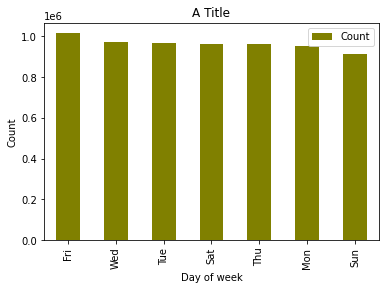

In [ ]:
# now import pandas and matplotlib to plot stuff
import pandas as pd
import matplotlib.pyplot as plt
cp = pd.DataFrame({'Day_of_week':dow, 'Count':cnt})
cp.head(7)
cp.sort_values('Count', ascending=False).plot(kind='bar', color='olive',x='Day_of_week', y='Count')
plt.xlabel('Day of week')
plt.ylabel('Count')
plt.title('A Title')